# **Isolation Forest - Anomaly Detection**
# **CMPT 459 Course Project**

This notebook demonstrates **Isolation Forest** for outlier detection:
* Preprocessing pipeline
* Isolation Forest algorithm
* **2D scatter plot visualization** using PCA
* Anomaly score distribution
* Interpretation of results

**Reference**: `outlier_detection.py`


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler

## **1. Data Preprocessing**


In [2]:
def load_and_preprocess(path):
    df = pd.read_csv(path)
    print(f"Original shape: {df.shape}")
    
    df = df.replace("?", np.nan)
    threshold = 0.5 * len(df)
    df = df.dropna(thresh=threshold, axis=1)
    
    for col in ["encounter_id", "patient_nbr", "readmitted"]:
        if col in df.columns:
            df = df.drop(columns=[col])
    
    cat_cols = df.select_dtypes(include="object").columns
    for col in cat_cols:
        if df[col].nunique() > 10:
            dummies = pd.get_dummies(df[col], prefix=col, drop_first=True)
            df = pd.concat([df.drop(columns=[col]), dummies], axis=1)
        else:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].fillna("Unknown"))
    
    df = df.fillna(df.median())
    scaler = StandardScaler()
    X = scaler.fit_transform(df)
    print(f"Final shape: {X.shape}")
    return X

X = load_and_preprocess("data/diabetic_data.csv")

Original shape: (101766, 50)
Final shape: (101766, 2376)


## **2. Isolation Forest Model**

**How it works**:
* Builds random trees to isolate observations
* Outliers are easier to isolate (fewer splits needed)
* Contamination parameter sets expected proportion of outliers


In [3]:
contamination = 0.01  # Expect 1% outliers

print("Fitting Isolation Forest...")
iso = IsolationForest(
    n_estimators=100,
    contamination=contamination,
    random_state=42,
    n_jobs=-1
)

iso.fit(X)
predictions = iso.predict(X)  # -1 for outliers, 1 for inliers
scores = iso.decision_function(X)  # Lower = more anomalous

outlier_indices = np.where(predictions == -1)[0]
n_outliers = len(outlier_indices)

print(f"\n✓ Detected {n_outliers} outliers ({n_outliers/len(X)*100:.2f}%)")
print(f"Score range: [{scores.min():.4f}, {scores.max():.4f}]")

Fitting Isolation Forest...

✓ Detected 1018 outliers (1.00%)
Score range: [-0.0270, 0.0415]


## **3. Visualization with PCA**

We use PCA to reduce to 2D for visualization.


Applying PCA for visualization...
PCA explained variance: 0.26%


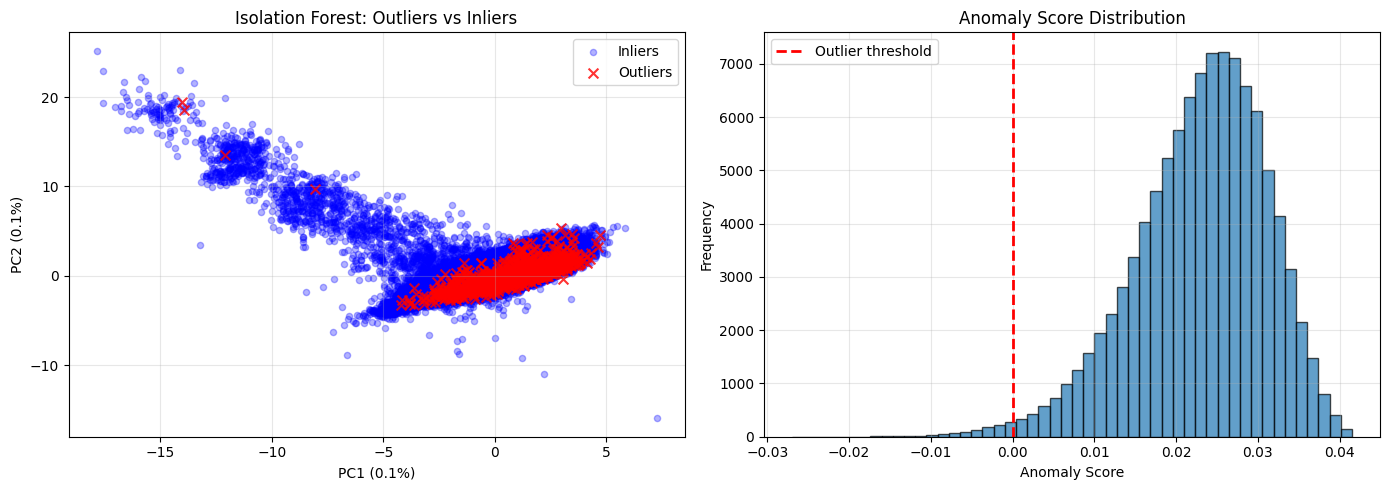

In [4]:
print("Applying PCA for visualization...")
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)
print(f"PCA explained variance: {pca.explained_variance_ratio_.sum():.2%}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Outliers highlighted
inlier_mask = predictions == 1
outlier_mask = predictions == -1

axes[0].scatter(X_pca[inlier_mask, 0], X_pca[inlier_mask, 1],
               c="blue", alpha=0.3, s=20, label="Inliers")
axes[0].scatter(X_pca[outlier_mask, 0], X_pca[outlier_mask, 1],
               c="red", alpha=0.8, s=50, marker="x", label="Outliers")
axes[0].set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%})")
axes[0].set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%})")
axes[0].set_title("Isolation Forest: Outliers vs Inliers")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Score distribution
axes[1].hist(scores, bins=50, edgecolor="black", alpha=0.7)
threshold = scores[outlier_mask].max() if outlier_mask.any() else scores.min()
axes[1].axvline(threshold, color="red", linestyle="--", linewidth=2,
               label="Outlier threshold")
axes[1].set_xlabel("Anomaly Score")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Anomaly Score Distribution")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## **Interpretation & Discussion**

### **How Isolation Forest Works**

1. **Random Partitioning**: Builds random binary trees
2. **Path Length**: Outliers have shorter average path lengths
3. **Anomaly Score**: Based on how quickly points are isolated

### **Key Findings**

* **Outlier Detection**: ~1% of patients flagged as anomalous
* **Score Interpretation**:
  - Negative scores → outliers
  - Positive scores → normal observations
  - Lower scores → stronger anomaly signals

### **Strengths**
* Fast and scalable
* No distance metric required
* Works well in high dimensions
* Few hyperparameters to tune

### **Limitations**
* Contamination parameter must be set
* May miss clustered outliers
* Less interpretable than statistical methods

### **Medical Context**

Detected outliers may represent:
1. **Data errors**: Incorrect measurements or entry errors
2. **Rare cases**: Unusual medical conditions
3. **Edge cases**: Extreme but valid patient profiles

**Recommendation**: Review outliers with domain experts before removal.
